In [1]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

In [213]:
from tqdm.notebook import tqdm
import pandas as pd
pd.set_option('display.max_colwidth', None)

# 0. Collect data

### Load documents

In [22]:
import datasets

LOAD_LOCALLY = False

if LOAD_LOCALLY:
    from pathlib import Path
    from datasets import Dataset

    docs = []
    sources = []
    for p in Path("./data/datasets/huggingface_docs/").iterdir():
        if not p.is_dir():
            with open(p) as f:
                # the first line is the source of the text
                source = f.readline().strip().replace('source: ', '').replace('https://github.com/', '')
                content = f.read()[2:] # Remove the initial '\n'
                if len(content) > 0:
                    docs.append(content)
                    sources.append(source)
        # break

    ds = Dataset.from_dict({"text": docs, "source": sources})
    ds.to_csv('./data/huggingface_doc.csv')
    print(f'number of documents: {len(ds)}')

else:
    ds = datasets.load_dataset("A-Roucher/huggingface_doc", split='train')

# 1. Setup evaluation pipeline
In this part, we build a synthetic dataset of questions and associated contexts.

In [183]:
eval_dataset

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answer', 'source_doc', 'standalone_score', 'standalone_eval', 'relatedness_score', 'relatedness_eval', 'relevance_score', 'relevance_eval'],
        num_rows: 81
    })
})

In [197]:
REBUILD_EVALUATION_DATASET = False

if not REBUILD_EVALUATION_DATASET:
    eval_dataset = datasets.load_dataset('A-Roucher/huggingface_doc_qa_eval')

Generating train split:   0%|          | 0/67 [00:00<?, ? examples/s]

### Prepare source documents

We use Langchain's `RecursiveCharacterTextSplitter`, which makes efficient use of code language detection to make better splits.

In [14]:
if REBUILD_EVALUATION_DATASET:
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    from langchain.docstore.document import Document as LangchainDocument

    langchain_docs = [LangchainDocument(page_content=doc['text'], metadata={'source': doc['source']}) for doc in tqdm(ds)]

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=2000, chunk_overlap=200, add_start_index=True, separators=["\n\n", "\n", ".", " ", ""]
    )

    docs_processed = []
    for doc in langchain_docs:
        docs_processed += text_splitter.split_documents([doc])

### Setup chains for question generation

In [15]:
if REBUILD_EVALUATION_DATASET:
    from langchain.prompts import ChatPromptTemplate
    from langchain.chat_models import ChatOpenAI

    QA_generation_prompt = """
    Your task is to write a factoid question and an answer given a context.
    Your factoid question should be answerable with a specific, concise piece of factual information from the context.
    Your factoid question should be formulated in the same style as questions users could ask in a search engine.
    This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

    Provide your answer as follows:

    Output:::
    Factoid question: (your factoid question)
    Answer: (your answer to the factoid question)

    Now here is the context.

    Context: {context}\n
    Output:::"""

    question_relatedness_critique_prompt = """
    You will be given a context and a question.
    Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
    Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

    Provide your answer as follows:

    Answer:::
    Evaluation: (your rationale for the rating)
    Total rating: (your rating)

    Now here are the question and context.

    Question: {question}\n
    Context: {context}\n
    Answer::: """

    question_relevance_critique_prompt = """
    You will be given a question.
    Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
    Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

    Rating must be minimum, i.e. 1, if the questions refers to a particular setting, like 'in the context' or 'in the document'.

    Provide your answer as follows:

    Answer:::
    Evaluation: (your rationale for the rating)
    Total rating: (your rating)

    Now here is the question.

    Question: {question}\n
    Answer::: """

    question_standalone_critique_prompt = """
    You will be given a question.
    Your task is to provide a 'total rating' representing how context-independant this question is.
    Give your answer on a scale of 1 to 5, where 1 means that the question only makes sense in a specific context, and 5 means that the question makes sense by itself.
    For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
    The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

    Provide your answer as follows:

    Answer:::
    Evaluation: (your rationale for the rating)
    Total rating: (your rating)

    Now here is the question.

    Question: {question}\n
    Answer::: """

    chat_model = ChatOpenAI(model="gpt-4-1106-preview", temperature=0.2)
    QA_generation_prompt = ChatPromptTemplate.from_template(QA_generation_prompt)
    QA_generation_chain = QA_generation_prompt | chat_model

    question_relatedness_critique_prompt = ChatPromptTemplate.from_template(question_relatedness_critique_prompt)
    question_relatedness_critique_chain = question_relatedness_critique_prompt | chat_model

    question_relevance_critique_prompt = ChatPromptTemplate.from_template(question_relevance_critique_prompt)
    question_relevance_critique_chain = question_relevance_critique_prompt | chat_model

    question_standalone_critique_prompt = ChatPromptTemplate.from_template(question_standalone_critique_prompt)
    question_standalone_critique_chain = question_standalone_critique_prompt | chat_model

In [16]:
import random
if REBUILD_EVALUATION_DATASET:
    N_GENERATIONS = 30

    print(f"Generating {N_GENERATIONS} QA couples...")
    outputs = []
    for context in tqdm(random.sample(langchain_docs, N_GENERATIONS)):
        # Generate QA couple
        output_QA_couple = QA_generation_chain.invoke({"context": context.page_content}).content
        try:
            question = output_QA_couple.split('Factoid question: ')[1].split('Answer: ')[0]
            answer = output_QA_couple.split('Answer: ')[1]
            outputs.append(
                {
                    "context": context.page_content,
                    "question": question,
                    "answer": answer,
                    "source_doc": context.metadata['source'],
                }
            )
        except:
            continue

In [17]:
if REBUILD_EVALUATION_DATASET:
    print("Generating critique for each QA couple...")
    for output in tqdm(outputs):
        # Critique the generated QA couple
        question_relatedness_evaluation = question_relatedness_critique_chain.invoke({"context": output['context'], "question": output['question']}).content
        question_relevance_evaluation = question_relevance_critique_chain.invoke({"question": output['question']}).content
        question_standalone_evaluation = question_standalone_critique_chain.invoke({"question": output['question']}).content

        try:
            relatedness_score = int(question_relatedness_evaluation.split('Total rating: ')[1][0])
            relatedness_eval = question_relatedness_evaluation.split('Total rating: ')[0].split('Evaluation: ')[1]
            relevance_score = int(question_relevance_evaluation.split('Total rating: ')[1][0])
            relevance_eval = question_relevance_evaluation.split('Total rating: ')[0].split('Evaluation: ')[1]
            standalone_score = int(question_standalone_evaluation.split('Total rating: ')[1][0])
            standalone_eval = question_standalone_evaluation.split('Total rating: ')[0].split('Evaluation: ')[1]
            output.update({
                "relatedness_score": relatedness_score,
                "relatedness_eval": relatedness_eval,
                "relevance_score": relevance_score,
                "relevance_eval": relevance_eval,
                "standalone_score": standalone_score,
                "standalone_eval": standalone_eval,
            })
        except:
            continue

Filter down questions on the chosen criteria:

In [18]:
if REBUILD_EVALUATION_DATASET:
    import pandas as pd
    pd.set_option('display.max_colwidth', None)

    generated_questions = pd.DataFrame.from_dict(outputs)
    display(generated_questions.head())
    generated_questions = generated_questions.loc[(generated_questions['relatedness_score'] >= 4) & (generated_questions['relevance_score'] >= 3) & (generated_questions['standalone_score'] >= 4)]
    !pip install openpyxl
    generated_questions.to_excel("qa_eval.xlsx")
    display(generated_questions.head())

    eval_dataset = datasets.Dataset.from_pandas(generated_questions, split='train', preserve_index=False)

# 2. Build RAG System

## 2.1. Retriever - embeddings
Here we use Langchain vector databases since it offers a convenient FAISS index and allows us to keep document metadata throughout the processing.


Options:
- change embedding model
- normal embeddings vs instruct embeddings
- Hyde
- reranker

### Preprocessing

In this part, we split the documennts from our knowledge base into smaller chunks which will be the snippets that will support our answer. The goal is to have semantically relevant snippets: not too small to be sufficient for supporting an answer, and not too large in order to be centered around a key information.

We do this chunking with the `haystack` library, which offers a good `PreProcessor` class.

[This space](https://huggingface.co/spaces/A-Roucher/chunk_visualizer) lets you visualize how different chunking options affect the chunks you get, to help you tune this step.

Options:
- split respecting sentence boundaries
- semantic splits

In [115]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

langchain_docs = [LangchainDocument(page_content=doc['text'], metadata={'source': doc['source']}) for doc in tqdm(ds)]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100, add_start_index=True, separators=["\n\n", "\n", ".", " ", ""]
)

docs_processed = []
for doc in langchain_docs:
    docs_processed += text_splitter.split_documents([doc])

  0%|          | 0/2647 [00:00<?, ?it/s]

<Axes: >

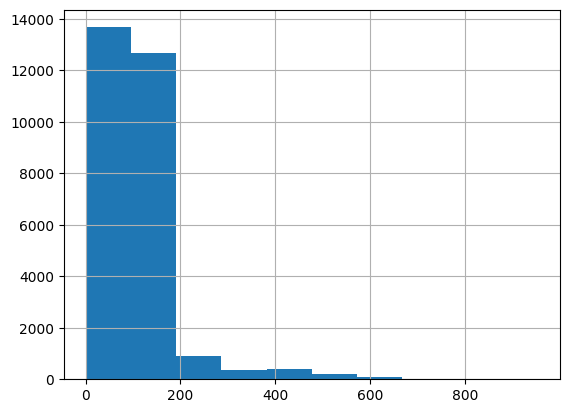

In [118]:
pd.Series([len(doc.page_content.split(' ')) for doc in docs_processed]).hist()

In [119]:
from langchain.embeddings import HuggingFaceEmbeddings, HuggingFaceInstructEmbeddings

USE_INSTRUCT_EMBEDDINGS = False

if not USE_INSTRUCT_EMBEDDINGS:
    model_name = 'BAAI/bge-base-en-v1.5'
    embedding_model = HuggingFaceEmbeddings(model_name=model_name, multi_process=True)

else:
    model_name = "hkunlp/instructor-large"
    embed_instruction = "Represent the Hugging Face library documentation"
    query_instruction = "Query the most relevant piece of information from the Hugging Face documentation"

    embedding_model = HuggingFaceInstructEmbeddings(
        model_name=model_name,
        embed_instruction=embed_instruction,
        query_instruction=query_instruction
    )

⬇️🚨 The cell below takes 15min to run on A10G!

In [120]:
from langchain.vectorstores import FAISS

index = FAISS.from_documents(docs_processed, embedding_model)

index_name = 'index_1000'
index.save_local(f'./data/indexes/{index_name}/')

#### Test retrieval:

In [ ]:
docs = index.similarity_search(query='how to create a pipeline object?', k=5)
print(docs[0].page_content)
print(docs[0].metadata)

!--⚠️ Note that this file is in Markdown but contain specific syntax for our doc-builder (similar to MDX) that may not be
rendered properly in your Markdown viewer.
-->

# Using pipelines for a webserver

<Tip>
Creating an inference engine is a complex topic, and the "best" solution 
will most likely depend on your problem space. Are you on CPU or GPU? Do
you want the lowest latency, the highest throughput, support for
many models, or just highly optimize 1 specific model?
There are many ways to tackle this topic, so what we are going to present is a good default
to get started which may not necessarily be the most optimal solution for you.
</Tip>


The key thing to understand is that we can use an iterator, just like you would [on a
dataset](pipeline_tutorial#using-pipelines-on-a-dataset), since a webserver is basically a system that waits for requests and
treats them as they come in.

Usually webservers are multiplexed (multithreaded, async, etc..) to handle various
requests concurre

In [121]:
KNOWLEDGE_INDEX = FAISS.load_local(f'./data/indexes/{index_name}/', embedding_model)

from sentence_transformers import CrossEncoder

RERANKER = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2')

## 2.2 Reader - LLM
Options:
- zero-shot vs few-shot prompting (cf [resource](https://cookbook.openai.com/examples/fine-tuned_qa/ft_retrieval_augmented_generation_qdrant#6-using-qdrant-to-improve-rag-prompt))
- tune the number of examples retrieved
- make conversational

In [122]:
prompt_template = """
<|system|>
Using the information contained in the context, 
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
{context}
---
Now here is the question you need to answer.

Question: {question}
  </s>
<|assistant|>
"""

In [95]:
from transformers import pipeline

llm = pipeline("text-generation", model='HuggingFaceH4/zephyr-7b-beta')

llm('Ok,', max_new_tokens=512)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

/home/ubuntu/venv/ml2/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


KeyboardInterrupt: 

In [130]:
import requests
import os

API_URL = "https://ytjpei7t003tedav.us-east-1.aws.endpoints.huggingface.cloud"

headers = {
	"Authorization": f"Bearer {os.getenv('HF_TOKEN')}",
	"Content-Type": "application/json"
}

def get_llm_answer(question):
	payload = {
		"inputs": question,
		"max_new_tokens": 3000,
	}
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

In [226]:
def answer_question(question, llm, knowledge_index, reranker, num_retrieved_docs: int = 15, num_reranked_docs: int = 7, use_reranker=True):
    # Gather documents with retriever
        
    relevant_docs = knowledge_index.similarity_search(
        query=question,
        k=num_retrieved_docs
    )

    if use_reranker:
        # Select the most relevant documents with reranker
        cross_encoding_predictions = reranker.predict(
            [(question, doc.page_content) for doc in relevant_docs]
        )
        relevant_docs = [
            doc for _, doc in sorted(
                zip(cross_encoding_predictions, relevant_docs),
                reverse=True, key = lambda x: x[0]
            )
        ]

    relevant_docs = relevant_docs[:num_reranked_docs]

    # Build the final prompt
    context = '\nExtracted documents:\n'
    context += ''.join([f"{str(i)}: " + doc.page_content for i, doc in enumerate(relevant_docs)])

    final_prompt = prompt_template.format(
        context=context,
        question=question
    )
    print('Finished retrieving. Redacting answer...')
    # Redact an answer
    answer = llm(final_prompt)[0]['generated_text']

    return answer, relevant_docs

## 2.3 Test

In [148]:
question = "how to create a pipeline object?"
answer, relevant_docs = answer_question(question, get_llm_answer, KNOWLEDGE_INDEX, RERANKER)

Finished retrieving. Redacting answer...


In [149]:
print(f'Answer: {answer}')
print('\n\nSource documents:')
for doc in relevant_docs:
    print(f'{doc.metadata["source"]}')
    print(doc.page_content)

# 3. Benchmarking the final system on your evaluation set

In [ ]:
import json

try: # load previous generations if they exist
    with open(f'output/rag_evaluation_results_noreranker.json', 'r') as f:
        outputs = json.load(f)
except:
    outputs = []


for example in tqdm(eval_dataset['train']):
    question = example['question']
    if question in [output['question'] for output in outputs]:
        continue

    answer, relevant_docs = answer_question(question, get_llm_answer, KNOWLEDGE_INDEX, RERANKER, use_reranker=False)
    print(':::::::')
    print(f'Question: {question}')
    print(f'Answer: {answer}')
    print(f'True answer: {example["answer"]}')
    outputs.append({
        "question": question,
        "true_answer": example['answer'],
        "source_doc": example['source_doc'],
        "generated_answer": answer,
        "retrieved_docs": [doc.page_content for doc in relevant_docs],
    })

    with open(f'output/rag_evaluation_results_noreranker.json', 'w') as f:
        json.dump(outputs, f)

In [205]:
EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

###Feedback:"""

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain.schema import SystemMessage


evaluation_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="You are a fair evaluator language model."),
        HumanMessagePromptTemplate.from_template(EVALUATION_PROMPT),
    ]
)

In [209]:
from langchain.chat_models import ChatOpenAI

eval_chat_model = ChatOpenAI(model='gpt-4-1106-preview', temperature=0)
evaluator_name = "GPT4"

for experiment in tqdm(outputs):
    if f'eval_score_{evaluator_name}' in experiment:
        continue

    eval_prompt = evaluation_prompt_template.format_messages(
        instruction=experiment['question'],
        response=experiment['generated_answer'],
        reference_answer=experiment["true_answer"],
    )
    eval_result = eval_chat_model.invoke(eval_prompt)
    feedback, score = [
        item.strip() for item in eval_result.content.split("[RESULT]")
    ]
    experiment[f'eval_score_{evaluator_name}'] = score
    experiment[f'eval_feedback_{evaluator_name}'] = feedback

    with open(f'output/rag_evaluation_results.json', 'w') as f:
        json.dump(outputs, f)

  0%|          | 0/67 [00:00<?, ?it/s]

In [210]:
results_df = pd.DataFrame(outputs)
results_df = results_df.loc[~results_df['eval_feedback_GPT4'].isna()]
results_df['eval_score_GPT4'] = results_df['eval_score_GPT4'].astype(int)
performance_percentage = (results_df['eval_score_GPT4'] - 1).mean() / 4 # We convert the 1-5 int scale to a 0-1 float scale

In [216]:
results_df.loc[results_df['eval_score_GPT4'] < 3].head()

question  \
33  What library does MarkupLMFeatureExtractor use to extract data from HTML and XML files?\n   
59              What is the command to upload an ESPnet model to a Hugging Face repository?\n   
65  What parameter is used to ensure that elements in a row have the same height in Gradio?\n   

                                                                 true_answer  \
33                                                            Beautiful Soup   
59  ./run.sh --stage 15 --skip_upload_hf false --hf_repo username/model_repo   
65                                                              equal_height   

                                                                                source_doc  \
33                 huggingface/transformers/blob/main/docs/source/en/model_doc/markuplm.md   
59                                       huggingface/hub-docs/blob/main/docs/hub/espnet.md   
65  gradio-app/gradio/blob/main/guides/cn/03_building-with-blocks/02_controlling-layout.md   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                generated_answer  \
33  The library used by MarkupLMFeatureExtractor to extract data from HTML and XML files is Beautiful Soup, as mentioned in the context provided. This information can be found in the usage instructions for MarkupLMProcessor, specifically in the documentation for the `MarkupLMFeatureExtractor` class. However, it should be noted that while using Beautiful Soup is the easiest way to prepare data for the model, it is not a requirement. The context also explains that users can still provide their   
59                                                                                                              The command to upload an ESPnet model to a Hugging Face repository is:\n\n```bash\nespnet_model.push_to_hub("my-awesome-model")\n```\n\nThis command is part of the `espnet` toolkit for speech processing, which can be found in the Hugging Face Hub. To learn more about sharing models with Hugging Face, refer to the official guide provided in the context. Additionally, you can use the   
65                                                                                                 The parameter used to ensure that elements in a row have the same height in Gradio is the `grow` parameter in the `Row` component. When set to True for a component, it will grow to fill any remaining vertical space in the row. This ensures that all components in the row have the same height. Here's an example:\n\n```python\nimport gradio as gr\n\nwith gr.Blocks() as demo:\n    with gr.Row(grow=   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [211]:
performance_percentage

0.8246268656716418